In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.insert(0, os.path.abspath(".."))
from src.config import cfg  # noqa: E402
from src.features import compute_cutoff_date

In [2]:
path = f"{Path().resolve().parent}/{cfg['data']['processed_path']}"
df = pd.read_parquet(path)

print(df.columns.tolist())
pd.set_option("display.max_columns", None)
print(df['auth'].unique())
df.head()

['ts', 'userId', 'sessionId', 'page', 'auth', 'method', 'status', 'level', 'itemInSession', 'location', 'userAgent', 'lastName', 'firstName', 'registration', 'gender', 'artist', 'song', 'length', 'ts_dt', 'registration_dt', 'os', 'browser', 'device', 'city', 'region', 'country']
<StringArray>
['Logged In', 'Cancelled']
Length: 2, dtype: string


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length,ts_dt,registration_dt,os,browser,device,city,region,country
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1532063507000,M,Martin Orford,Grand Designs,597.55057,2018-10-01 00:00:11+00:00,2018-07-20 05:11:47+00:00,macOS,Chrome,Desktop,Corpus Christi,TX,USA
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1538069638000,M,John Brown's Body,Bulls,380.21179,2018-10-01 00:00:25+00:00,2018-09-27 17:33:58+00:00,macOS,Chrome,Desktop,Houston-The Woodlands-Sugar Land,TX,USA
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1535953455000,M,Afroman,Because I Got High,202.37016,2018-10-01 00:01:58+00:00,2018-09-03 05:44:15+00:00,macOS,Chrome,Desktop,Orlando-Kissimmee-Sanford,FL,USA
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1535953455000,M,<NA>,<NA>,NaN,2018-10-01 00:01:59+00:00,2018-09-03 05:44:15+00:00,macOS,Chrome,Desktop,Orlando-Kissimmee-Sanford,FL,USA
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1535931018000,F,Lily Allen,Smile (Radio Edit),194.53342,2018-10-01 00:02:04+00:00,2018-09-02 23:30:18+00:00,Windows,Firefox,Desktop,Mobile,AL,USA


In [3]:
cutoff_date = compute_cutoff_date(df)
df_feat = df[df["ts_dt"] <= cutoff_date].copy()
df_targ = df[df["ts_dt"] > cutoff_date].copy()

all_users = df["userId"].value_counts()
users_in_feature_window = df_feat["userId"].value_counts()
users_in_target_window = df_targ["userId"].value_counts()

print(f'{len(all_users)=}')
print(f'{len(users_in_feature_window)=}')
print(f'{len(users_in_target_window)=}')

2025-10-09 01:40:12,856 | INFO | src.features: last_month_start 2018-11-01 00:00:00+00:00
2025-10-09 01:40:12,856 | INFO | src.features: cutoff_date 2018-10-31 00:00:00+00:00


max_date 2018-12-01 00:00:00+00:00
len(all_users)=448
len(users_in_feature_window)=426
len(users_in_target_window)=385


In [4]:
df.groupby("userId")["ts_dt"].max().sort_values().head(10)


userId
208      2018-10-01 13:30:16+00:00
137      2018-10-01 20:58:07+00:00
231      2018-10-02 12:19:53+00:00
100001   2018-10-02 14:50:59+00:00
100013   2018-10-02 19:13:11+00:00
300050   2018-10-03 00:41:02+00:00
236      2018-10-03 04:11:11+00:00
100030   2018-10-03 13:17:15+00:00
156      2018-10-03 18:48:49+00:00
100032   2018-10-04 09:58:15+00:00
Name: ts_dt, dtype: datetime64[ms, UTC]

### Date Fields
The date fields: ts timestamp for every log, registration user signup data
so we're using timestamp for log

In [5]:
print('min', df["ts_dt"].min())
print('max', df["ts_dt"].max())

min 2018-10-01 00:00:11+00:00
max 2018-12-01 00:01:06+00:00


<pre lang="markdown">2018-10-01 |---------------------------| 2018-10-31 |--------------------------->| 2018-12-01
<br>            ^ features window (31 days)  ^ cut-off   ^ outcome window (31 days)</pre>

Feature Window: 2018-10-01 ──► 2018-10-31  (cut-off day included)<br>
Target Window:  2018-11-01 ──► 2018-12-01  (31 days future)<br>

Cut-off: 2018-10-31<br>
Inactivity threshold: 31 days<br>
Use ts_dt for all calculations (ignore registration_dt for churn labeling).

## Data Exploration

In [6]:
CUTT_OFF_DATE = "2018-10-31"

In [7]:
processed_path = f"{Path().resolve().parent}/{cfg['data']['processed_path']}"
labeled_path = f"{Path().resolve().parent}/{cfg['data']['labeled_path']}"
features_path = f"{Path().resolve().parent}/{cfg['data']['features_path']}"

processed = pd.read_parquet(processed_path)
labeled = pd.read_parquet(labeled_path)
features = pd.read_parquet(features_path)

### A. Demographics & static info

#### Prepare a Customer-Level Table
1. `tenure_days`: the number of days since user registered till the cut-off date


In [8]:
# Get first registration & most common device/region/gender for each user
cust_df = (
    processed.groupby("userId").agg(
        registration_dt=("registration_dt", "first"),       # earliest sign-up
        gender=("gender", "first"),                          # mostly static
        region=("region", lambda x: x.mode().iloc[0] if len(x.mode())>0 else None),
        device=("device", lambda x: x.mode().iloc[0] if len(x.mode())>0 else None),
    ).reset_index()
)

# Compute Tenure in days at cutoff
cutoff_date = pd.Timestamp(CUTT_OFF_DATE, tz="UTC")
cust_df["tenure_days"] = (cutoff_date - cust_df["registration_dt"]).dt.days

# Join churn labels
cust_df = cust_df.merge(labeled[["userId","churn"]], on="userId", how="left")
cust_df.head()


,userId,registration_dt,gender,region,device,tenure_days,churn
0,10,2018-09-28 18:31:35+00:00,M,MS,Desktop,32,1
1,100,2018-09-26 17:17:35+00:00,M,TX,Desktop,34,0
2,100001,2018-08-18 21:24:26+00:00,F,FL,Desktop,73,1
3,100002,2018-06-25 13:51:29+00:00,F,CA,Desktop,127,0
4,100003,2018-09-18 22:22:24+00:00,F,FL,Desktop,42,0


#### Explore Gender vs Churn

In [9]:
print(cust_df["gender"].value_counts(dropna=False))
pd.crosstab(cust_df["gender"], cust_df["churn"], normalize="index") * 100

gender
M    250
F    198
Name: count, dtype: int64


churn,0,1
gender,,
F,84.343434,15.656566
M,84.000000,16.000000


#### Explore Region vs Churn

In [10]:
top_regions = cust_df["region"].value_counts().head(10).index
pd.crosstab(cust_df.loc[cust_df["region"].isin(top_regions),"region"],
            cust_df["churn"],
            normalize="index") * 100

churn,0,1
region,,
AZ,80.000000,20.000000
CA,87.096774,12.903226
CT,66.666667,33.333333
FL,84.615385,15.384615
GA,91.666667,8.333333
IN,70.000000,30.000000
MI,81.818182,18.181818
NC,100.000000,0.000000
TX,94.444444,5.555556


#### Explore Device Preference vs Churn

In [11]:
pd.crosstab(cust_df["device"], cust_df["churn"], normalize="index") * 100

churn,0,1
device,,
Desktop,84.798100,15.201900
Mobile,74.074074,25.925926


#### Explore Tenure vs Churn

In [12]:
# Quick numeric bins
cust_df["tenure_bins"] = pd.cut(cust_df["tenure_days"],
                                bins=[0,30,90,180,365,9999],
                                labels=["<1mo","1-3mo","3-6mo","6-12mo",">12mo"])

pd.crosstab(cust_df["tenure_bins"], cust_df["churn"], normalize="index") * 100


churn,0,1
tenure_bins,,
<1mo,80.952381,19.047619
1-3mo,84.393064,15.606936
3-6mo,82.857143,17.142857
6-12mo,87.500000,12.500000


#### Prep: filter to feature window & set snapshot date

In [13]:
from datetime import timedelta

import pandas as pd

cutoff_date = pd.Timestamp(CUTT_OFF_DATE, tz="UTC")

# keep only events up to cutoff
feat_df = processed[processed["ts_dt"] <= cutoff_date].copy()
feat_df["date"] = feat_df["ts_dt"].dt.date     # convenient daily granularity

#### 2. Recency
`recency_days`: number of days between last activity and the cut-off date

In [14]:
recency = (
    feat_df.groupby("userId")["ts_dt"]
           .max()
           .reset_index()
           .rename(columns={"ts_dt": "last_activity"})
)
recency["recency_days"] = (cutoff_date - recency["last_activity"]).dt.days

recency

,userId,last_activity,recency_days
0,10,2018-10-09 03:22:44+00:00,21
1,100,2018-10-27 11:15:12+00:00,3
2,100001,2018-10-02 14:50:59+00:00,28
3,100002,2018-10-30 05:30:08+00:00,0
4,100003,2018-10-28 13:36:03+00:00,2
...,...,...,...
421,95,2018-10-27 19:29:17+00:00,3
422,96,2018-10-30 23:56:38+00:00,0
423,97,2018-10-30 01:53:34+00:00,0
424,98,2018-10-25 20:38:53+00:00,5


### 3. Frequency
`freq`: number of sessions / log events in rolling windows

In [15]:
def count_in_window(days):
    start = cutoff_date - timedelta(days=days)
    mask = feat_df["ts_dt"].between(start, cutoff_date)
    return (
        feat_df.loc[mask]
               .groupby("userId")["sessionId"]
               .nunique()
               .rename(f"freq_{days}d")
    )

freq_7d  = count_in_window(7)
freq_30d = count_in_window(30)
freq_90d = count_in_window(90)

frequency = pd.concat([freq_7d, freq_30d, freq_90d], axis=1).fillna(0).astype(int)
# frequency.loc["10"]

frequency

,freq_7d,freq_30d,freq_90d
userId,,,
100,3,13,13
100002,1,3,3
100003,1,5,5
100007,2,7,7
100008,1,3,3
...,...,...,...
68,0,2,2
71,0,1,1
75,0,3,3


#### 4. Consistency
Compute #events per week → variance / std-dev.<br>
Showing variability of weekly activity

In [16]:
feat_df["week"] = feat_df["ts_dt"].dt.to_period("W").apply(lambda r: r.start_time)

weekly_counts = (
    feat_df.groupby(["userId","week"])["sessionId"]
           .nunique()
           .reset_index()
           .rename(columns={"sessionId":"weekly_sessions"})
)

consistency = (
    weekly_counts.groupby("userId")["weekly_sessions"]
                 .agg(weekly_var="var", weekly_std="std", weekly_mean="mean")
)

consistency

/var/folders/lt/yb6yj7rs5_566mgz0b3c9hd00000gn/T/ipykernel_75388/237692350.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  feat_df["week"] = feat_df["ts_dt"].dt.to_period("W").apply(lambda r: r.start_time)


,weekly_var,weekly_std,weekly_mean
userId,,,
10,NaN,NaN,1.000000
100,2.916667,1.707825,3.250000
100001,NaN,NaN,3.000000
100002,0.000000,0.000000,1.000000
100003,1.333333,1.154701,1.666667
...,...,...,...
95,2.916667,1.707825,3.750000
96,0.500000,0.707107,2.000000
97,3.800000,1.949359,2.400000


#### 5. Trend
slope of recent weekly activity<br>
Compute slope of session counts in the last 2–4 weeks.<br>

Negative slope → declining engagement → higher churn risk.

In [17]:


def slope_last_weeks(user_df, weeks=4):
    # take only last N weeks
    user_df = user_df.tail(weeks)
    if len(user_df) < 2:
        return 0
    x = np.arange(len(user_df))
    y = user_df["weekly_sessions"].values
    # linear regression slope
    return np.polyfit(x, y, 1)[0]

trend = (
    weekly_counts.groupby("userId")
                 .apply(slope_last_weeks)
                 .rename("activity_slope")
)
trend

/var/folders/lt/yb6yj7rs5_566mgz0b3c9hd00000gn/T/ipykernel_75388/2367505346.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(slope_last_weeks)


userId
10        0.000000e+00
100      -1.000000e-01
100001    0.000000e+00
100002    9.930137e-17
100003    3.972055e-16
              ...     
95        1.300000e+00
96        4.000000e-01
97       -1.300000e+00
98       -1.000000e-01
99        2.000000e-01
Name: activity_slope, Length: 426, dtype: float64

### 6. Session Length
avg / std-dev of session durations

Approximate using `ts_dt` within each `sessionId`

In [18]:
session_stats = (
    feat_df.groupby(["userId","sessionId"])["ts_dt"]
           .agg(["min","max"])
           .reset_index()
)
session_stats["duration_min"] = (session_stats["max"] - session_stats["min"]).dt.total_seconds()/60

session_features = (
    session_stats.groupby("userId")["duration_min"]
                 .agg(avg_session_len="mean", std_session_len="std")
)
session_features

,avg_session_len,std_session_len
userId,,
10,1502.400000,NaN
100,396.888462,358.429493
100001,137.661111,84.399856
100002,89.205556,32.652958
100003,366.583333,527.535892
...,...,...
95,294.848889,197.097528
96,347.940000,404.367186
97,193.693056,178.275461


#### 7. Content Diversity
unique pages and unique songs a user interacted with.

In [19]:
diversity = (
    feat_df.groupby("userId")
           .agg(
               unique_pages=("page","nunique"),
               unique_songs=("song","nunique"),
               unique_artists=("artist","nunique"),
           )
)
diversity

,unique_pages,unique_songs,unique_artists
userId,,,
10,13,350,306
100,15,1175,946
100001,14,96,93
100002,9,64,59
100003,16,447,402
...,...,...,...
95,13,980,773
96,13,781,683
97,13,539,474


#### Combine all engagement features

In [20]:
eng_features = (
    recency
    .set_index("userId")
    .join([freq_7d, freq_30d, freq_90d,
           consistency, trend, session_features, diversity])
    .reset_index()
)

eng_features.head()

,userId,last_activity,recency_days,freq_7d,freq_30d,freq_90d,weekly_var,weekly_std,weekly_mean,activity_slope,avg_session_len,std_session_len,unique_pages,unique_songs,unique_artists
0,10,2018-10-09 03:22:44+00:00,21,NaN,1,1,NaN,NaN,1.000000,0.000000e+00,1502.400000,NaN,13,350,306
1,100,2018-10-27 11:15:12+00:00,3,3.0,13,13,2.916667,1.707825,3.250000,-1.000000e-01,396.888462,358.429493,15,1175,946
2,100001,2018-10-02 14:50:59+00:00,28,NaN,3,3,NaN,NaN,3.000000,0.000000e+00,137.661111,84.399856,14,96,93
3,100002,2018-10-30 05:30:08+00:00,0,1.0,3,3,0.000000,0.000000,1.000000,9.930137e-17,89.205556,32.652958,9,64,59
4,100003,2018-10-28 13:36:03+00:00,2,1.0,5,5,1.333333,1.154701,1.666667,3.972055e-16,366.583333,527.535892,16,447,402


Join churn labels with engagement features

In [21]:
eng = eng_features.merge(labeled[["userId","churn"]], on="userId", how="left")
eng

,userId,last_activity,recency_days,freq_7d,freq_30d,freq_90d,weekly_var,weekly_std,weekly_mean,activity_slope,avg_session_len,std_session_len,unique_pages,unique_songs,unique_artists,churn
0,10,2018-10-09 03:22:44+00:00,21,NaN,1,1,NaN,NaN,1.000000,0.000000e+00,1502.400000,NaN,13,350,306,1
1,100,2018-10-27 11:15:12+00:00,3,3.0,13,13,2.916667,1.707825,3.250000,-1.000000e-01,396.888462,358.429493,15,1175,946,0
2,100001,2018-10-02 14:50:59+00:00,28,NaN,3,3,NaN,NaN,3.000000,0.000000e+00,137.661111,84.399856,14,96,93,1
3,100002,2018-10-30 05:30:08+00:00,0,1.0,3,3,0.000000,0.000000,1.000000,9.930137e-17,89.205556,32.652958,9,64,59,0
4,100003,2018-10-28 13:36:03+00:00,2,1.0,5,5,1.333333,1.154701,1.666667,3.972055e-16,366.583333,527.535892,16,447,402,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,95,2018-10-27 19:29:17+00:00,3,5.0,15,15,2.916667,1.707825,3.750000,1.300000e+00,294.848889,197.097528,13,980,773,0
422,96,2018-10-30 23:56:38+00:00,0,5.0,10,10,0.500000,0.707107,2.000000,4.000000e-01,347.940000,404.367186,13,781,683,0
423,97,2018-10-30 01:53:34+00:00,0,2.0,12,12,3.800000,1.949359,2.400000,-1.300000e+00,193.693056,178.275461,13,539,474,0
424,98,2018-10-25 20:38:53+00:00,5,3.0,14,14,0.250000,0.500000,3.750000,-1.000000e-01,384.008333,532.611693,16,1138,917,0


#### Explore Patterns

<Axes: title={'center': 'activity_slope'}, xlabel='churn'>

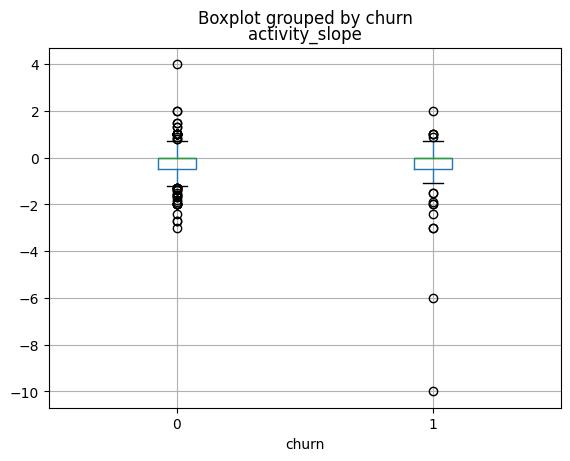

In [22]:
# Recency distribution by churn
eng.groupby("churn")["recency_days"].describe()

# Churn rate vs frequency bins
pd.crosstab(pd.cut(eng["freq_30d"], bins=[0,1,5,10,20,999]),
            eng["churn"], normalize="index") * 100

# Scatter: slope vs churn
eng.boxplot(column="activity_slope", by="churn")


### Features List

In [23]:
eng.head()

,userId,last_activity,recency_days,freq_7d,freq_30d,freq_90d,weekly_var,weekly_std,weekly_mean,activity_slope,avg_session_len,std_session_len,unique_pages,unique_songs,unique_artists,churn
0,10,2018-10-09 03:22:44+00:00,21,NaN,1,1,NaN,NaN,1.000000,0.000000e+00,1502.400000,NaN,13,350,306,1
1,100,2018-10-27 11:15:12+00:00,3,3.0,13,13,2.916667,1.707825,3.250000,-1.000000e-01,396.888462,358.429493,15,1175,946,0
2,100001,2018-10-02 14:50:59+00:00,28,NaN,3,3,NaN,NaN,3.000000,0.000000e+00,137.661111,84.399856,14,96,93,1
3,100002,2018-10-30 05:30:08+00:00,0,1.0,3,3,0.000000,0.000000,1.000000,9.930137e-17,89.205556,32.652958,9,64,59,0
4,100003,2018-10-28 13:36:03+00:00,2,1.0,5,5,1.333333,1.154701,1.666667,3.972055e-16,366.583333,527.535892,16,447,402,0


In [24]:
cust_df.head()

,userId,registration_dt,gender,region,device,tenure_days,churn,tenure_bins
0,10,2018-09-28 18:31:35+00:00,M,MS,Desktop,32,1,1-3mo
1,100,2018-09-26 17:17:35+00:00,M,TX,Desktop,34,0,1-3mo
2,100001,2018-08-18 21:24:26+00:00,F,FL,Desktop,73,1,1-3mo
3,100002,2018-06-25 13:51:29+00:00,F,CA,Desktop,127,0,3-6mo
4,100003,2018-09-18 22:22:24+00:00,F,FL,Desktop,42,0,1-3mo


In [25]:
processed_features = processed[processed["ts_dt"] <= cutoff_date].copy()

print(processed_features.columns.tolist())
processed_features.head()

['ts', 'userId', 'sessionId', 'page', 'auth', 'method', 'status', 'level', 'itemInSession', 'location', 'userAgent', 'lastName', 'firstName', 'registration', 'gender', 'artist', 'song', 'length', 'ts_dt', 'registration_dt', 'os', 'browser', 'device', 'city', 'region', 'country']


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length,ts_dt,registration_dt,os,browser,device,city,region,country
0,1538352011000,293,292,NextSong,Logged In,PUT,200,free,20,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Morales,Joseph,1532063507000,M,Martin Orford,Grand Designs,597.55057,2018-10-01 00:00:11+00:00,2018-07-20 05:11:47+00:00,macOS,Chrome,Desktop,Corpus Christi,TX,USA
1,1538352025000,98,97,NextSong,Logged In,PUT,200,free,74,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Larson,Sawyer,1538069638000,M,John Brown's Body,Bulls,380.21179,2018-10-01 00:00:25+00:00,2018-09-27 17:33:58+00:00,macOS,Chrome,Desktop,Houston-The Woodlands-Sugar Land,TX,USA
2,1538352118000,179,178,NextSong,Logged In,PUT,200,paid,184,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1535953455000,M,Afroman,Because I Got High,202.37016,2018-10-01 00:01:58+00:00,2018-09-03 05:44:15+00:00,macOS,Chrome,Desktop,Orlando-Kissimmee-Sanford,FL,USA
3,1538352119000,179,178,Logout,Logged In,PUT,307,paid,185,"Orlando-Kissimmee-Sanford, FL","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Santiago,Maverick,1535953455000,M,<NA>,<NA>,NaN,2018-10-01 00:01:59+00:00,2018-09-03 05:44:15+00:00,macOS,Chrome,Desktop,Orlando-Kissimmee-Sanford,FL,USA
4,1538352124000,246,245,NextSong,Logged In,PUT,200,paid,22,"Mobile, AL",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Campos,Gianna,1535931018000,F,Lily Allen,Smile (Radio Edit),194.53342,2018-10-01 00:02:04+00:00,2018-09-02 23:30:18+00:00,Windows,Firefox,Desktop,Mobile,AL,USA


In [26]:
features_users = (
    processed.groupby("userId").agg(
        registration_dt=("registration_dt", "first"),       # earliest sign-up
        gender=("gender", "first"),                          # mostly static
        region=("region", lambda x: x.mode().iloc[0] if len(x.mode())>0 else None),
        device=("device", lambda x: x.mode().iloc[0] if len(x.mode())>0 else None),
    ).reset_index()
)

30 features - 7 areas

1. Demographics (6): gender, region. device, tenure_days, signup_cohort, account_age_group
2. Engagement (6): recency_days, (freq_7d, freq_30d, freq_90d), active_days_ratio, longest_gap_days, weekend_ratio, night_ratio
3. CONSISTENCY (3): (weekly_var, weekly_std, weekly_mean), activity_slope, momentum_ratio
4. SESSION-LEVEL (4): total_sessions, (avg_session_len_min, std_session_len_min), total_play_time_min, sessions_per_active_day
5. DIVERSITY (4): unique_pages, unique_songs, unique_artists, diversity_ratio
6. ACCOUNT(4): current_level, level_changes, time_as_paid_days, auth_fail_ratio
7. DERIVED (3): engagement_ratio, diversity_per_session, session_len_change_pct

In [27]:
cust_df = (
    processed.groupby("userId").agg(
        registration_dt=("registration_dt", "first"),       # earliest sign-up
        gender=("gender", "first"),                          # mostly static
        region=("region", lambda x: x.mode().iloc[0] if len(x.mode())>0 else None),
        device=("device", lambda x: x.mode().iloc[0] if len(x.mode())>0 else None),
    ).reset_index()
)

## Understand the distribution in Features & Target

In [28]:
print(labeled.columns.tolist())
print(labeled['churn'].value_counts())
labeled.head()

['userId', 'churn']
churn
0    377
1     71
Name: count, dtype: int64


,userId,churn
0,10,1
1,100,0
2,100001,1
3,100002,0
4,100003,0


In [29]:
labeled.describe()

,churn
count,448.000000
mean,0.158482
std,0.365601
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [30]:
features.describe()

,tenure_days,last_ts_dt,freq_7d,freq_30d,freq_90d,active_days_ratio,longest_gap_days,weekend_ratio,night_ratio,weekly_mean,weekly_std,weekly_var,activity_slope,momentum_ratio,total_sessions,avg_session_len_min,std_session_len_min,total_play_time_min,sessions_per_active_day,unique_pages,unique_songs,unique_artists,diversity_ratio,level_changes,time_as_paid_days,auth_fail_ratio,engagement_ratio,diversity_per_session,session_len_change_pct
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.0
mean,65.058685,6.685446,1.633803,7.687793,7.687793,0.241178,9.880282,0.146228,0.336361,2.177230,0.834052,1.405086,-0.181221,1.001469,7.687793,250.485474,213.040895,2027.055001,0.993136,11.870892,450.781690,376.894366,0.960571,0.572770,9.176056,0.000822,30.787224,56.753171,0.0
std,37.447486,7.991738,2.042417,7.113777,7.113777,0.187184,7.827387,0.173035,0.242189,1.404811,0.843275,3.244349,0.873519,0.460548,7.113777,194.079258,181.909051,2427.747680,0.209023,3.516649,509.848344,381.820112,0.058680,0.800359,10.461784,0.004678,6.479718,42.772703,0.0
min,17.000000,0.000000,0.000000,1.000000,1.000000,0.032258,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-10.000000,0.182000,1.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.500000,0.000000,0.0
25%,39.000000,0.000000,0.000000,3.000000,3.000000,0.096774,5.000000,0.000000,0.200000,1.050000,0.000000,0.000000,-0.500000,0.750000,3.000000,113.495833,76.668933,439.717488,0.900000,10.000000,106.500000,103.000000,0.944432,0.000000,0.000000,0.000000,27.900000,27.250000,0.0
50%,53.500000,4.000000,1.000000,5.000000,5.000000,0.193548,7.000000,0.111111,0.333333,1.800000,0.707107,0.500000,0.000000,1.000000,5.000000,212.818287,174.809354,1066.638189,1.000000,12.000000,252.500000,233.500000,0.971791,0.000000,3.000000,0.000000,31.000000,49.045455,0.0
75%,80.750000,10.000000,2.000000,10.000000,10.000000,0.354839,12.000000,0.230769,0.500000,2.500000,1.290994,1.666667,0.000000,1.000000,10.000000,324.512500,303.784723,2678.993361,1.044508,15.000000,609.250000,533.000000,0.990575,1.000000,19.000000,0.000000,32.379735,72.946429,0.0
max,359.000000,29.000000,12.000000,42.000000,42.000000,0.903226,31.000000,1.000000,1.000000,9.000000,7.071068,50.000000,4.000000,3.500000,42.000000,1510.566667,1033.695952,14286.543690,1.826087,19.000000,2872.000000,1981.000000,1.000000,5.000000,30.000000,0.077000,56.608696,352.000000,0.0


In [31]:
ignored_columns = ['sessionId', 'ts', 'userId', 'ts_dt', 'registration', 'registration_dt', 'userAgent', 'firstName', 'lastName', 'location', 'itemInSession'
    'city', 'region', 'country', 'city', 'song', 'artist']
important_columns = [x for x in features.columns if x not in ignored_columns]

numeric_colmns = features.select_dtypes(include='number').columns.tolist()
categorical_colmns = [x for x in features.columns if x not in numeric_colmns]

In [32]:
for col in features.columns:
    if col not in ignored_columns:
        print(col, features[col].unique())
        print('---'*40)

gender ['M', 'F']
Categories (2, object): ['F', 'M']
------------------------------------------------------------------------------------------------------------------------
device ['Desktop' 'Mobile']
------------------------------------------------------------------------------------------------------------------------
tenure_days [ 32  34  73 127  42 143  96  85  40  41  33  64  43  47  89  82  54  69
  39  35  49  53 218  74  30 161 102  71 113  76  44  75 138  79  60  68
  37  97  31  52  56  92  46 163  81  98 145  63 100  90  48  65  45  38
 104  58  77  55  93  88 359  50  70 109  36 101 155  57  61  67 111  72
  83 198 122  84 107  99  78  95 137 249 103 114  66  51 199 157  86 126
  59 202 210 121  62 106 164 117 140 123 120 105  17 135 226 118 130  94
  80  87]
------------------------------------------------------------------------------------------------------------------------
signup_cohort ['2018-09' '2018-08' '2018-06' '2018-07' '2018-03' '2018-05' '2017-11'
 '2018-04' 

In [33]:
features['session_len_change_pct']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
421    0.0
422    0.0
423    0.0
424    0.0
425    0.0
Name: session_len_change_pct, Length: 426, dtype: float64

#### Numeric Column Analysis

In [34]:
def plot_histogram(df, col):
    plt.figure(figsize=(5, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    
    col_mean = df[col].mean()
    col_median = df[col].median()
    
    plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
    plt.axvline(col_median, color="green", linestyle="--", label="Median")

    plt.legend()
    plt.show()

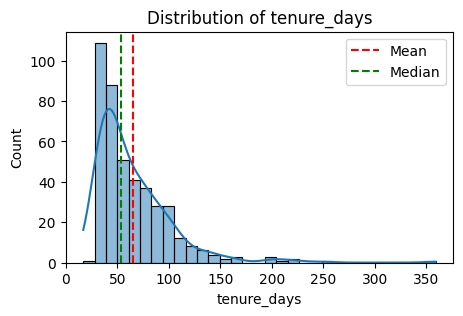

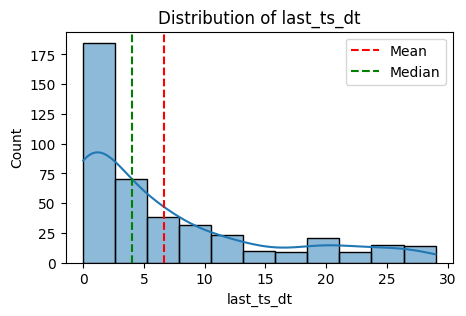

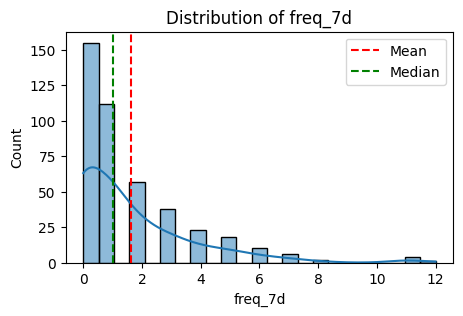

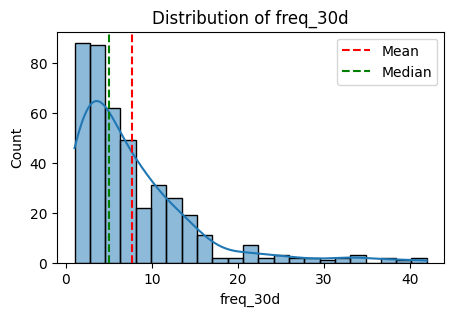

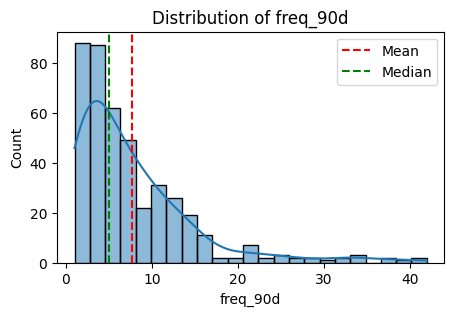

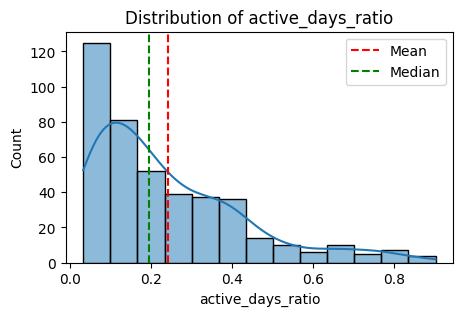

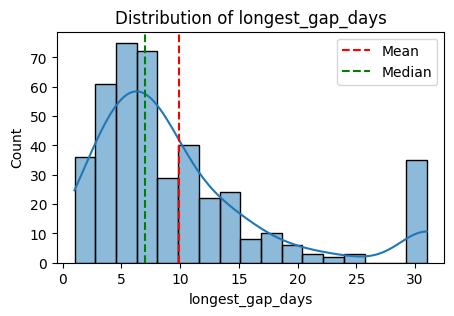

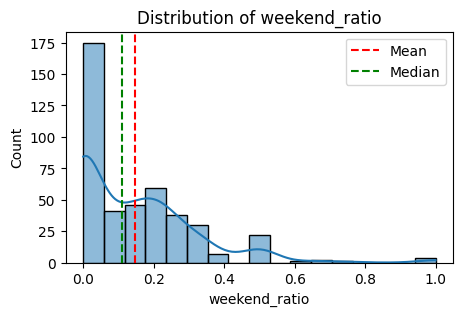

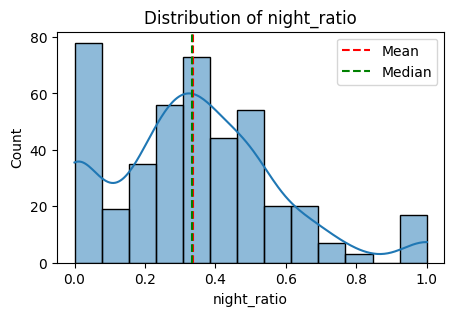

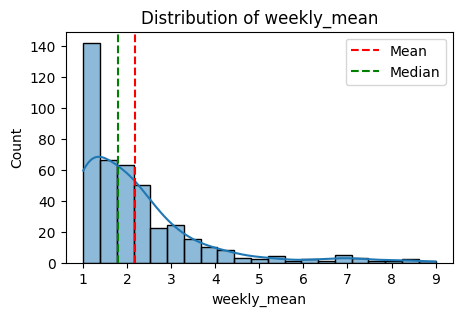

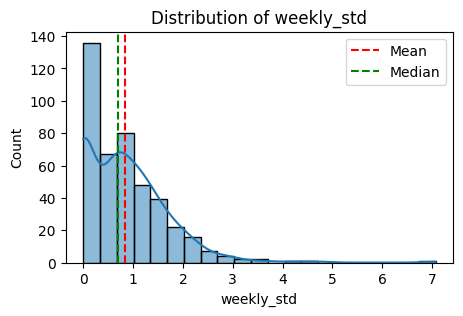

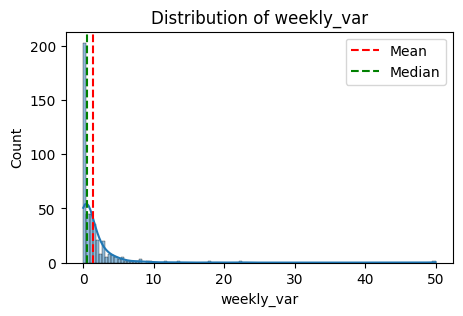

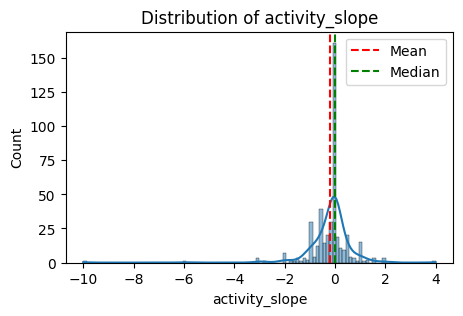

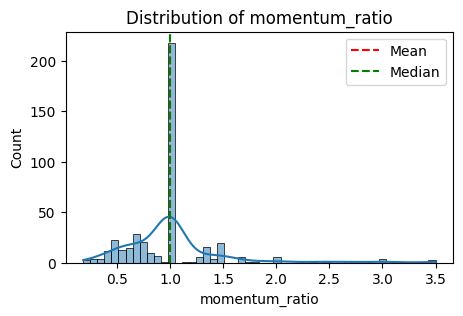

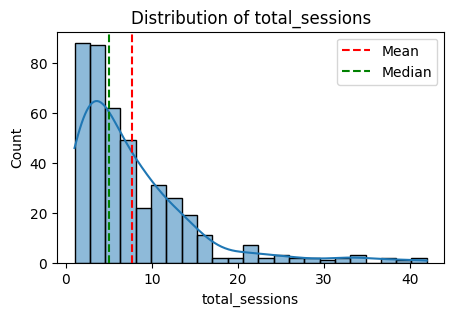

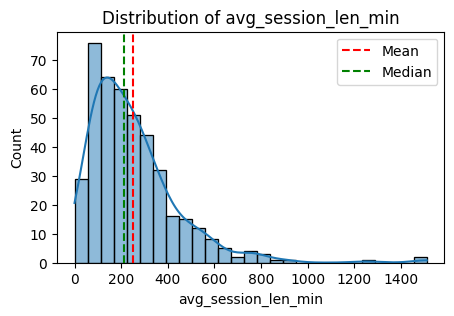

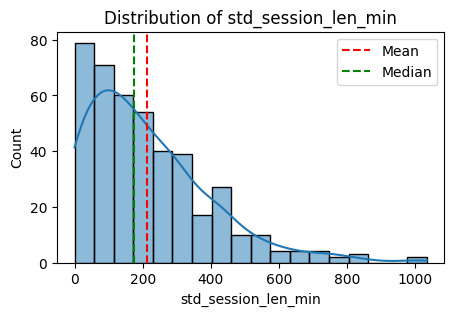

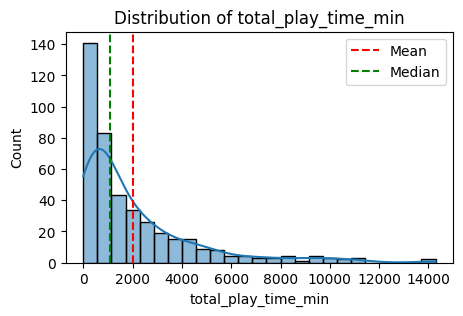

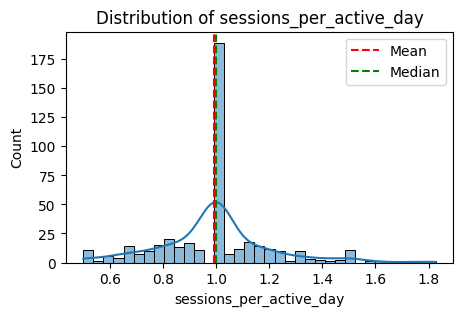

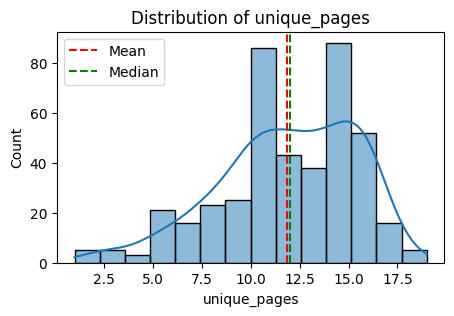

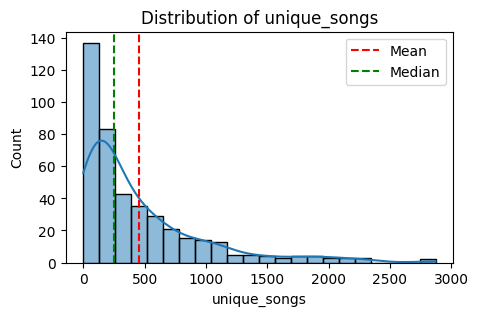

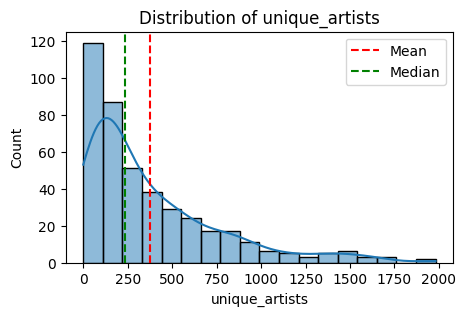

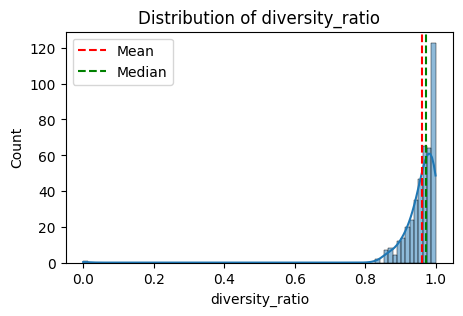

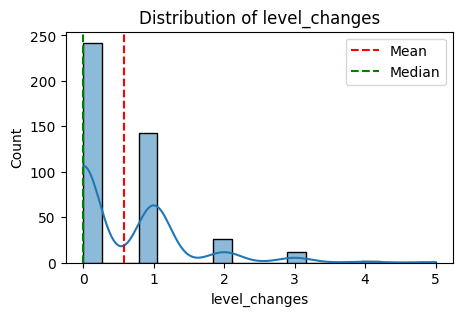

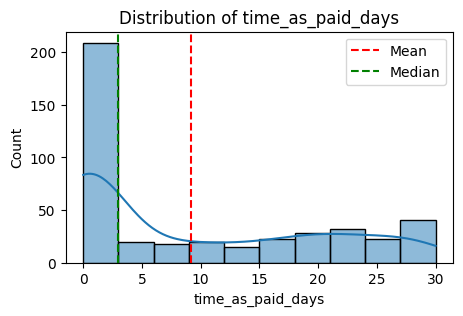

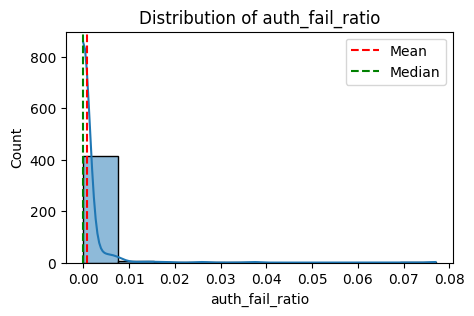

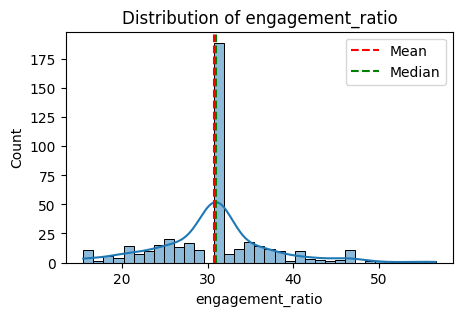

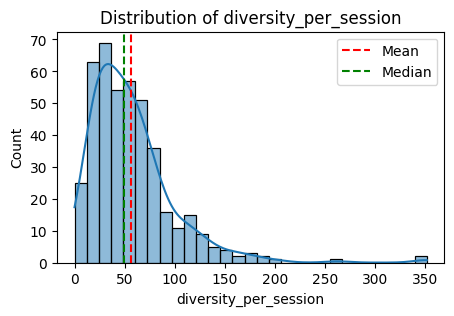

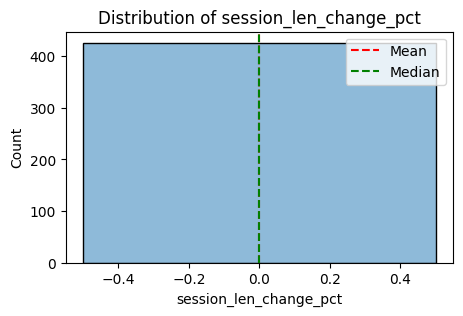

In [35]:
for col in features.columns:
    if col not in ignored_columns and col in numeric_colmns:
        plot_histogram(features, col)

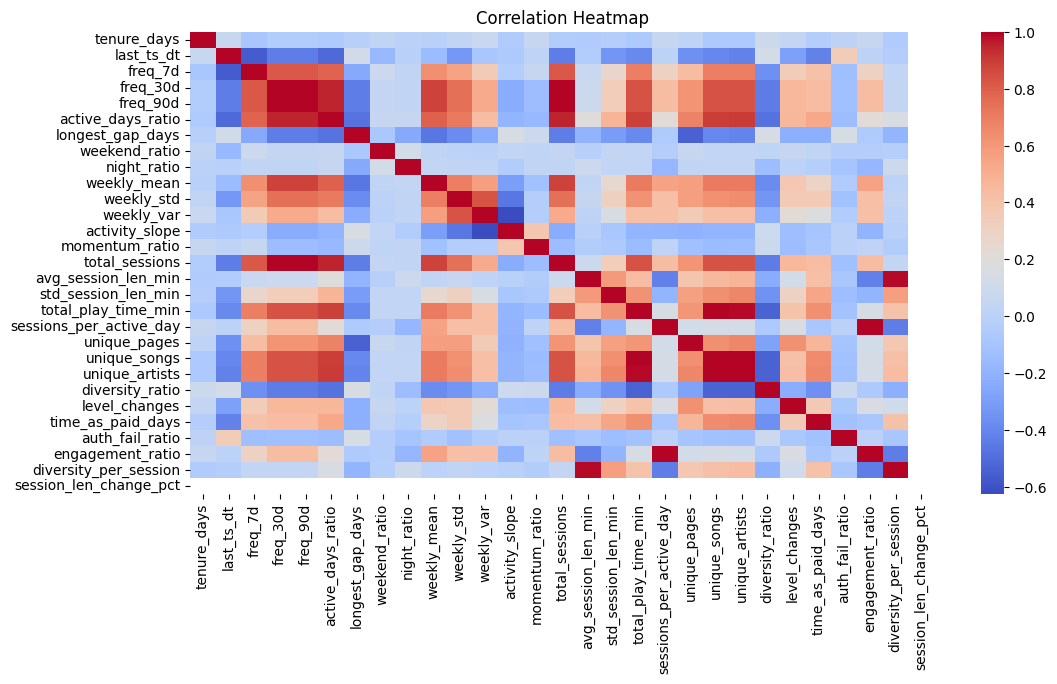

In [36]:
# correlation matrix - heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(features[numeric_colmns].corr(), cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### Categorical Columns Analysis

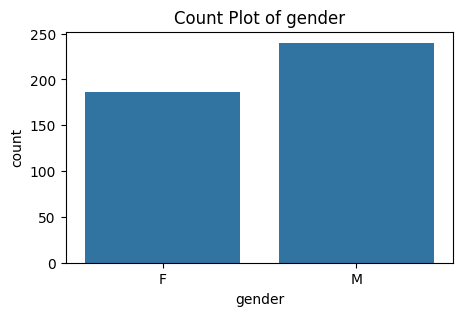

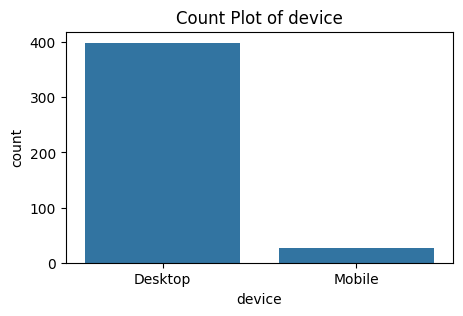

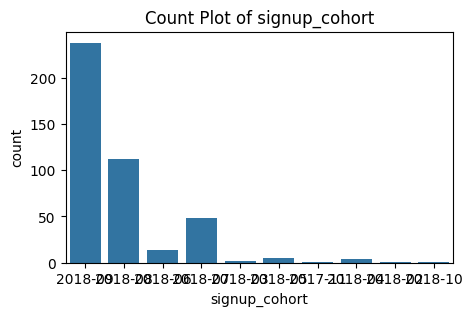

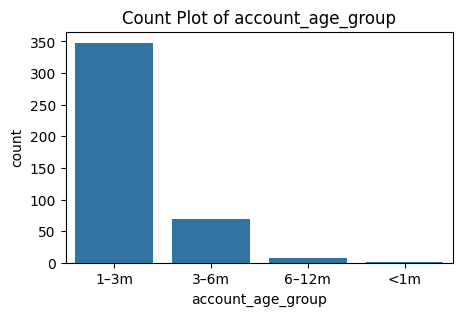

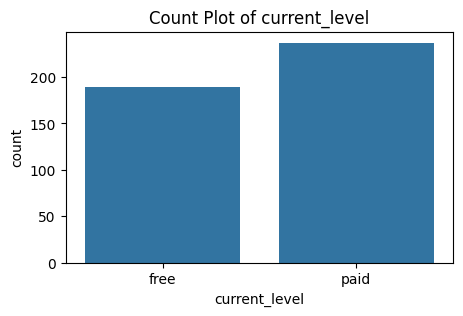

In [37]:
for col in categorical_colmns:
  if col in important_columns:
    plt.figure(figsize=(5, 3))
    sns.countplot(x=features[col])
    plt.title(f"Count Plot of {col}")
    plt.show()